# Chapter 7 Combining Different Models for Ensemble Learning

## Learning With Ensembles

The goal of **ensemble methods** is to combine different classifiers into a meta-classifier with better generalization performance.

The simplest form of ensemble methods use majority or plurality (in the case of multi-class) voting. The idea is that if error rates are uncorrelated, we can obtain a better estimate from multiple models.

Let's take a look at the effects of this assumption graphically.

In [1]:
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    """
    Returns ensemble error rate for number of classifiers all with
    the same uncorrelated error rate
    """
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
            for k in range(k_start, n_classifier + 1)]
    return sum(probs)
# test our function
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

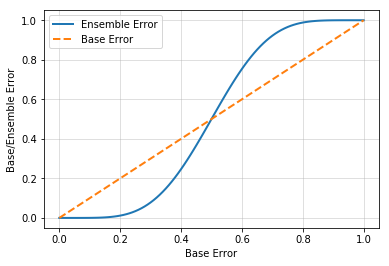

In [4]:
# now lets visualize the ensemble error across different base error rates
# of the underlying classifiers
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]

plt.plot(error_range, ens_errors,
        label='Ensemble Error',
        linewidth=2)
plt.plot(error_range, error_range,
        label='Base Error',
        linestyle='--',
        linewidth=2)
plt.xlabel('Base Error')
plt.ylabel('Base/Ensemble Error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

## Implementing a Simple Majority Vote Classifier

Common majority vote aggregating methods would include

- Polling and selecting majority class
- Polling and computing the majority class by weighting the votes
- Polling, getting class probabilities, and aggregating based on classifier weights

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.pipeline import _name_estimators
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """
    A majority vote ensemble classifier
    
    Parameters
    ----------
    classifiers : array - like, shape = [n_classifiers]
    
    vote : str {'classlabel', 'probability'}
        Default: 'classlabel'
        If 'classlabel' the prediction is based on the argmax
        of the class labels. Else if 'probability', the
        argmax of the sum of probabilities is used to
        predict the class label (recommended for calibrated classifiers)
        
    weights : array-like, shape = [n_classifiers]
        Optional, default: None
        If a list of 'int' or 'float' values are provided,
        the classifiers are weighted by importance.
        Uses uniform weights if weights=None
    """ 
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        
        self.classifiers = classifiers
        self.named_classifiers = {key : value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """
        Fit classifiers
        
        Parameters
        ----------
        X : array-like, spase matrix
            shape = [n_samples, n_features]
            Matrix of training samples
        
        y : array-like , shape = [n_samples]
            Vector target of class labels
            
        Returns
        --------
        self : object
        """
        
        # use label encoder to ensure class labels start with 0
        # this is important for np.argmax
        # which is called in self.predict
        
        self.labelenc_ = LabelEncoder()
        self.labelenc_.fit(y)
        self.classes_ = self.labelenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """
        Predict class labels for X
        
        Parameters
        ----------
        X : array-like, spase matrix
            shape = [n_samples, n_features]
            Matrix of training samples
            
        Returns
        ---------
        maj_vote : array_like, shape = [n_samples]
            Predicted class labels
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        
        else: # predicting by class label
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            
            maj_vote = np.apply_along_axis(lambda x:
                                          np.argmax(np.bincount(x, weights=self.weights)),
                                          axis=1,
                                          arr=predictions)
        
        # tranform classes back to original labels and return preds
        maj_vote = self.labelenc_.inverse_transform(maj_vote)
        return maj_vote
        
    def predict_proba(self, X):
        """
        Predict class probabilities for X
        
        Parameters
        ----------
        X : array-like, spase matrix
            shape = [n_samples, n_features]
            Matrix of training samples
            
        Returns
        ---------
        avg_proba : array-like
            shape = [n_samples, n_classes]
            Weighted average probability for
            each class per sample    
        """
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        
        return avg_proba
    
    def get_params(self, deep=True):
        """
        Get classifier parameter names for GridSearch
        """
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

## Using the Majority Voting Principle to Make Predictions

First, let's load up the iris dataset to play with.

In [10]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# load and split data
iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.5,
                                                   random_state=1,
                                                   stratify=y)

Using the training dataset, we ill train three different classifiers.

- Logistic regression
- Decision tree
- KNN

First, let's evaluate the performance of each individually.

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf1 = LogisticRegression(penalty='l2',
                          solver='lbfgs',
                         C=0.001,
                         random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,
                             criterion='entropy',
                             random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()],
                 ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                 ['clf', clf3]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print ('10 Fold Cross Validation: \n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring='roc_auc')
    print ('ROC AUC: %.2f (+/- .%.2f)' % (np.mean(scores), np.std(scores)), label)

10 Fold Cross Validation: 

ROC AUC: 0.87 (+/- .0.17) Logistic Regression
ROC AUC: 0.89 (+/- .0.16) Decision Tree
ROC AUC: 0.88 (+/- .0.15) KNN


Now, let's do the same cross validation, including our majority classifier.

In [15]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring='roc_auc')
    print ('ROC AUC: %.2f (+/- .%.2f)' % (np.mean(scores), np.std(scores)), label)

ROC AUC: 0.87 (+/- .0.17) Logistic Regression
ROC AUC: 0.89 (+/- .0.16) Decision Tree
ROC AUC: 0.88 (+/- .0.15) KNN
ROC AUC: 0.94 (+/- .0.13) Majority Voting


## Evaluating and Tuning the Ensemble Classifier

Let's take a look at ROC curves from the test data to check generalization performance.

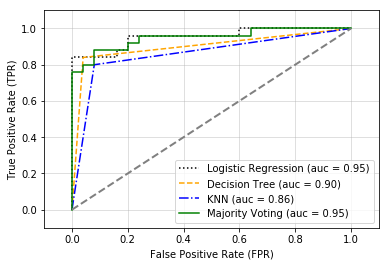

In [17]:
from sklearn.metrics import roc_curve, auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                    y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr,
            tpr,
            color=clr,
            linestyle=ls,
            label='%s (auc = %.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1],
        [0,1],
        linestyle='--',
        color='gray',
        linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

Next, let's visualize the decision regions for our classifiers.

To make this easier, we'll scale the data first, since our decision tree pipeline wouldn't do this for us.

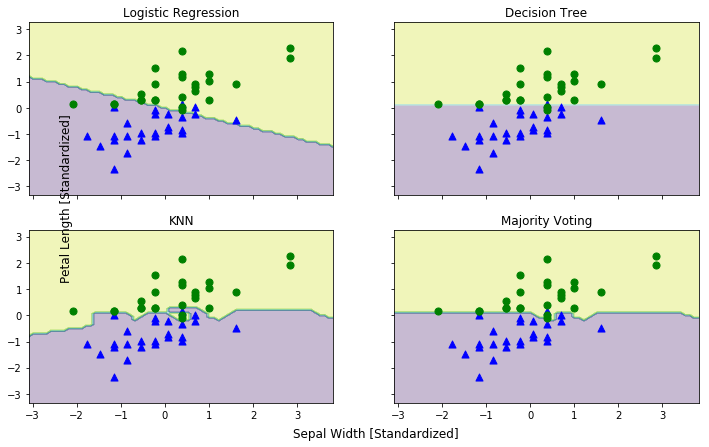

In [23]:
from itertools import product

# scaling data
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

# getting limits for coordinate axes plotting
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2,
                       sharex='col',
                       sharey='row',
                       figsize=(12,7))

for idx, clf, tt in zip(product([0, 1], [0,1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                               X_train_std[y_train==0, 1],
                               c='blue',
                               marker='^',
                               s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                               X_train_std[y_train==1, 1],
                               c='green',
                               marker='o',
                               s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -4.5,
        s='Sepal Width [Standardized]',
        ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5,
        s='Petal Length [Standardized]',
        ha='center', va='center',
        fontsize=12, rotation=90)
plt.show()

As expected, our majority classifier's decision boundary appears to be a combination of the other three classifiers.

Next, let's optimize the hyperparameters of our classifiers using GridSearch.

In [26]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth' : [1,2],
         'pipeline-1__clf__C' : [0.001, 0.01, 0.1, 100.0]}

# intialize and fit grid
grid = GridSearchCV(estimator=mv_clf,
                   param_grid=params,
                   cv=10,
                   scoring='roc_auc')
grid.fit(X_train, y_train)

# report best parameters and score
print ('Best parameters: %s' % grid.best_params_)
print ('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
Accuracy: 0.97


/Users/zach/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Bagging - Building An Ensemble of Classifiers From Bootstrap Samples

**Bagging** is a process in which we draw bootstrap samples from the initial training set to fit each of the individual classifiers in the ensemble. This results in each classifier having some duplicates and some original samples missing.

Let's apply bagging to classify samples in UCI's wine dataset.

In [30]:
# loading wine data
import pandas as pd
df_wine = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
                   'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 
                   'Proanthocyanins', 'Color intensity', 'hue', 'OD280/OD315 of diluted wines', 
                   'Proline']

# drop 1 class and select only 2 features
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol',
            'OD280/OD315 of diluted wines']].values

# encode labels as binary and split data
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=1,
                                                   stratify=y)

In [32]:
# implement bagging classifier using unpruned decision trees
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                             random_state=1,
                             max_depth=None)
bag = BaggingClassifier(base_estimator=tree,
                       n_estimators=500,
                       max_samples=1.0,
                       max_features=1.0,
                       bootstrap=True,
                       bootstrap_features=False,
                       n_jobs=-1,
                       random_state=1)

Let's compare the accuracy scores of the decision tree vs. our bagging classifier.

In [33]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
tree_train = accuracy_score(y_train, tree.predict(X_train))
tree_test = accuracy_score(y_test, tree.predict(X_test))
print ('Decision Tree Train/Test Accuracies: %.3f/%.3f' % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
bag_train = accuracy_score(y_train, bag.predict(X_train))
bag_test = accuracy_score(y_test, bag.predict(X_test))
print ('Bagging Train/Test Accuracies %.3f/%.3f' % (bag_train, bag_test))

Decision Tree Train/Test Accuracies: 1.000/0.833
Bagging Train/Test Accuracies 1.000/0.917


Next, let's compare the decision regions between our two classifiers.

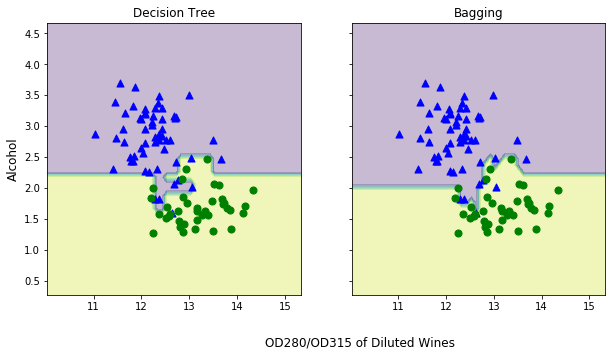

In [41]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2,
                       sharex='col',
                       sharey='row',
                       figsize=(10,5))

for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision Tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                               X_train[y_train==0, 1],
                               c='blue',
                               marker='^',
                               s=50)
    axarr[idx].scatter(X_train[y_train==1, 0],
                               X_train[y_train==1, 1],
                               c='green',
                               marker='o',
                               s=50)
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5,
        s='OD280/OD315 of Diluted Wines',
        ha='center', va='center',
        fontsize=12)
plt.show()

## Leveraging Weak Learners via Adaptive Boosting

In this section, we will focus on the most common implementation of boosting, **AdaBoost (Adaptive Boosting)**.

In boosting, the ensemble consists of very simple base classifiers, also referred to as *weak learners*. The key idea is to focus on training samples that are hard to classify by letting the weak learners learn from misclassified samples.

Let's take a look at the scikit learn implementation of AdaBoost.

In [43]:
from sklearn.ensemble import AdaBoostClassifier

# initialize decision tree and adaboost
tree = DecisionTreeClassifier(criterion='entropy',
                             random_state=1,
                             max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree,
                        n_estimators=500,
                        learning_rate=0.1,
                        random_state=1)

# fit and measure test accuracy
tree = tree.fit(X_train, y_train)
tree_train = accuracy_score(y_train, tree.predict(X_train))
tree_test = accuracy_score(y_test, tree.predict(X_test))
print ('Decision Tree Train/Test Accuracies: %.3f/%.3f' % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
ada_train = accuracy_score(y_train, ada.predict(X_train))
ada_test = accuracy_score(y_test, ada.predict(X_test))
print ('AdaBoost Train/Test Accuracies %.3f/%.3f' % (ada_train, ada_test))

Decision Tree Train/Test Accuracies: 0.916/0.875
AdaBoost Train/Test Accuracies 1.000/0.917


Similar to the bagging example, let's take a look at the decision regions for both the tree and adaboost.

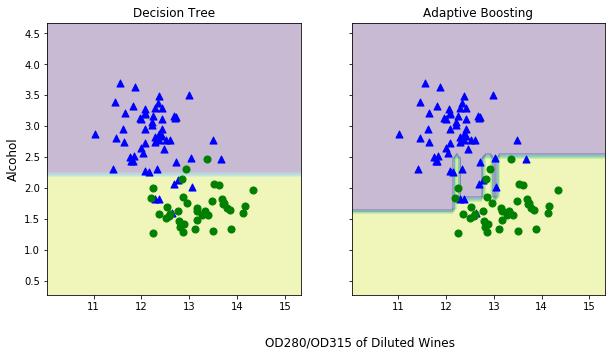

In [44]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2,
                       sharex='col',
                       sharey='row',
                       figsize=(10,5))

for idx, clf, tt in zip([0, 1], [tree, ada], ['Decision Tree', 'Adaptive Boosting']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                               X_train[y_train==0, 1],
                               c='blue',
                               marker='^',
                               s=50)
    axarr[idx].scatter(X_train[y_train==1, 0],
                               X_train[y_train==1, 1],
                               c='green',
                               marker='o',
                               s=50)
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5,
        s='OD280/OD315 of Diluted Wines',
        ha='center', va='center',
        fontsize=12)
plt.show()

Things worth noting about ensemble methods include 

- Boosting methods are known for overfitting the data in practice
- Ensemble learning increases the computational complexity compared to individual classifiers. In practice, we need to determine if the price of this additional complexity is worth the (often marginal) gain in predictive performance
- The key advantage of ensemble learning is combining individual classifiers to cancel out individual weaknesses